# Data Creation

RAG Optimization requires two types of data: QA dataset and Corpus dataset.

- QA dataset file (qa.parquet)

- Corpus dataset file (corpus.parquet)

QA dataset is important for accurate and reliable evaluation and optimization.

Corpus dataset is critical to the performance of RAGs. This is because RAG uses the corpus to retrieve documents and generate answers using it.

In this tutorial, we are using AutoRAG to parsing the raw document, chunking with various methods, making a QA dataset from it.
After generating QA dataset, we can make corresponding QA dataset to every corpus datasets.

With this tutorial, you can generate QA dataset from your own raw documents for optimizing RAG pipeline.

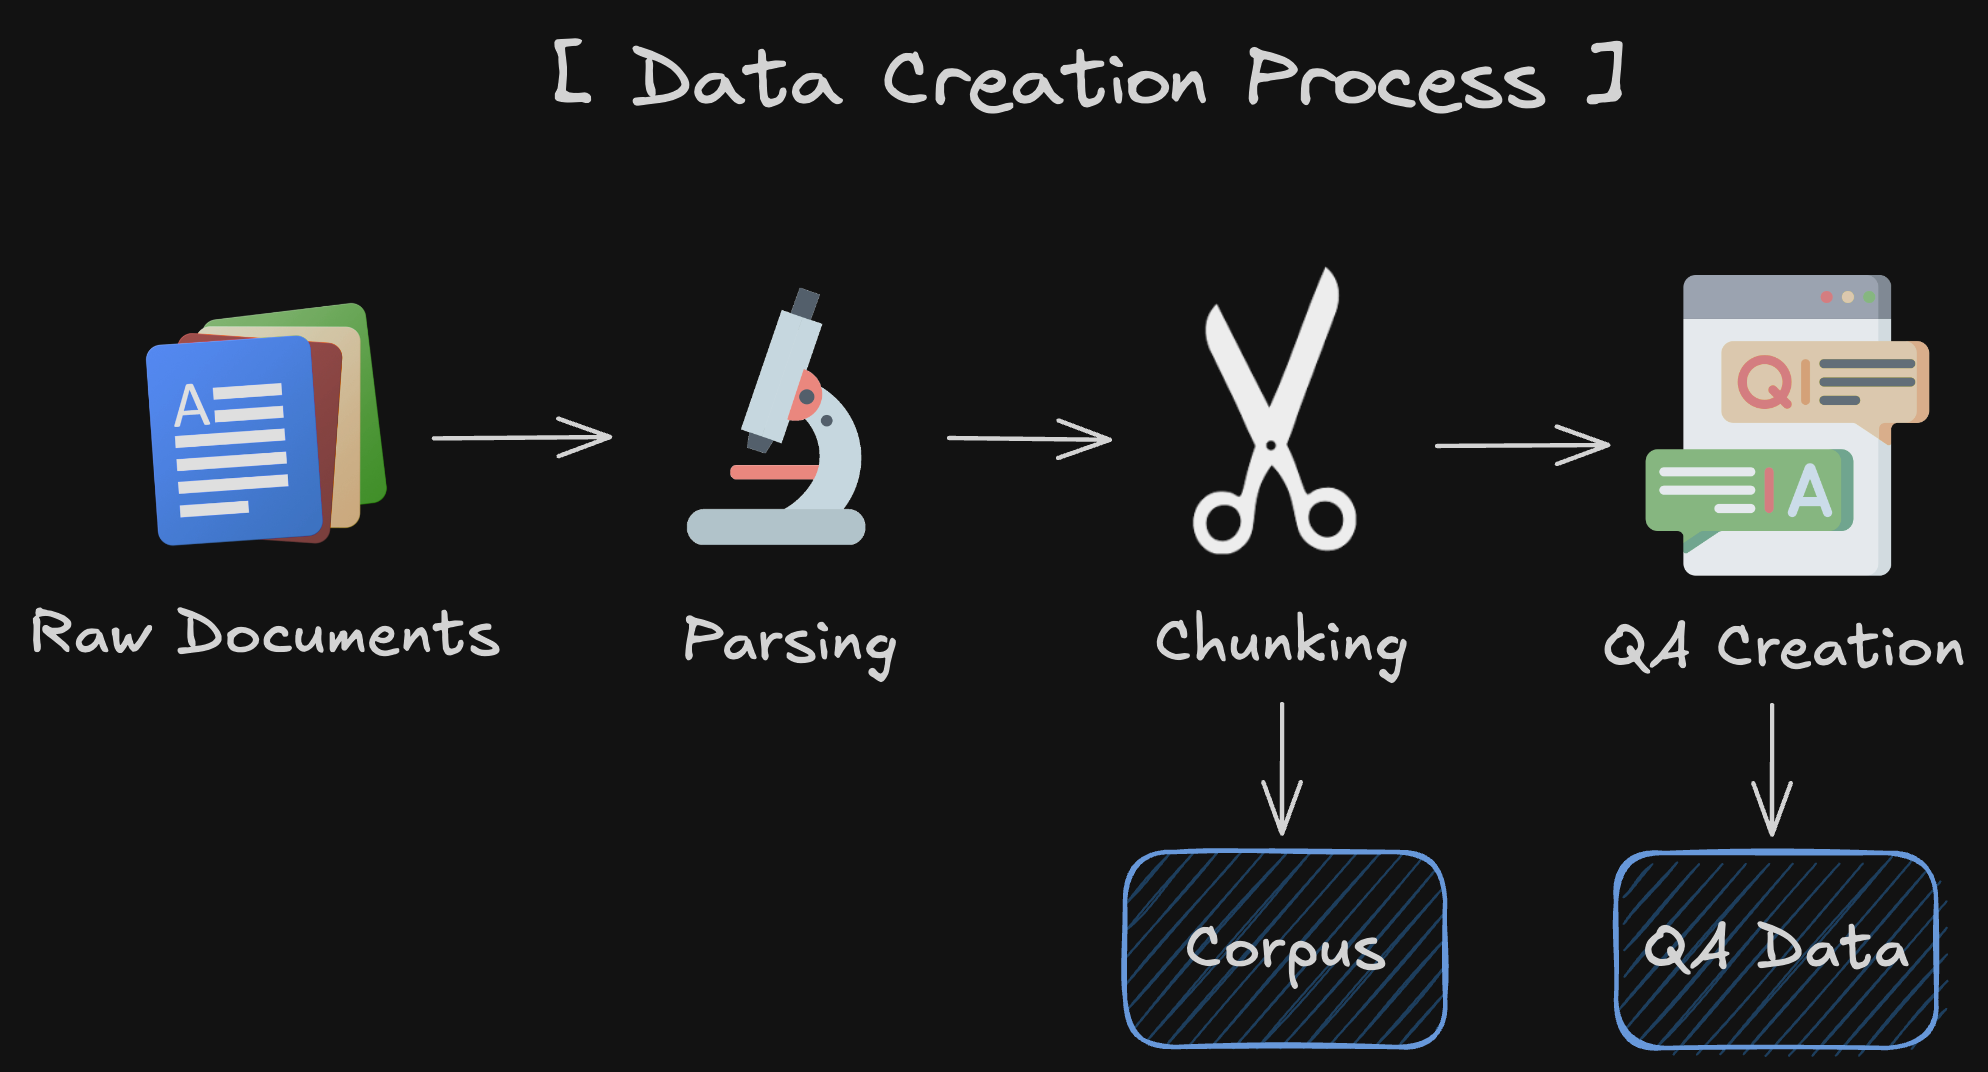

### Add OPENAI_API_KEY secret

At first, you need to add your openai api key at secrets.
Check out left side and go to 'Secrets' tab.
At there, press 'add new secret' and set name to `OPENAI_API_KEY`.
And set value to your openai api key.
Be sure to press toggle for notebook access!

If there are no error at below code, you are ready to go!

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import userdata
import os
openai_api_key = userdata.get('OPENAI_API_KEY')
assert bool(openai_api_key), "You have to set OPENAI_API_KEY at colab secrets."
os.environ["OPENAI_API_KEY"] = openai_api_key

In [ ]:
%%shell
apt-get remove python3-blinker
pip install blinker==1.8.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  distro-info-data gir1.2-glib-2.0 gir1.2-packagekitglib-1.0 libappstream4 libgirepository-1.0-1
  libglib2.0-bin libpackagekit-glib2-18 libpolkit-agent-1-0 libpolkit-gobject-1-0 libstemmer0d
  libxmlb2 libyaml-0-2 lsb-release packagekit pkexec policykit-1 polkitd python-apt-common
  python3-apt python3-cffi-backend python3-cryptography python3-dbus python3-distro python3-gi
  python3-httplib2 python3-importlib-metadata python3-jeepney python3-jwt python3-keyring
  python3-lazr.uri python3-more-itertools python3-pkg-resources python3-pyparsing
  python3-secretstorage python3-six python3-wadllib python3-zipp
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  python3-blinker python3-launchpadlib python3-lazr.restfulclient python3-oauthlib
  python3-software-properties software-propertie

In [ ]:
%pip install -Uq ipykernel==5.5.6 ipywidgets-bokeh==1.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.7/845.7 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.8 MB/s eta 0:00:00


In [ ]:
%pip install -Uq AutoRAG[parse]>=0.3.0 datasets

In [ ]:
import nest_asyncio
nest_asyncio.apply()

# Parsing

Parsing is the process to convert unstructured file to the text files.
You can parse with different methods of your raw document. You will get a `Raw` dataset from the parsing result.

You can use the `Raw` parquet files from the parsing result.

In [ ]:
%%writefile parse.yaml

modules:
  - module_type: langchain_parse
    parse_method: [pdfminer, pypdf]

Writing parse.yaml


With editing parse.yaml file, you can use various parsing methods easily. You can check what is the good method with investigating the result files.
You can check out what parsing module is supported in AutoRAG [here](https://edai.notion.site/Supporting-Parse-Modules-e0b7579c7c0e4fb2963e408eeccddd75).

In [ ]:
%pip install arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=c7df0436c708eba8625fd4bd4d8a40ba258c77ac8c3504b0e251a37dd7570f5a
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [ ]:
import os
os.makedirs('/content/raw_documents')

In [ ]:
# Download 3 pdfs from the arxiv

import arxiv

paper = next(arxiv.Client().results(arxiv.Search(id_list=["1605.08386v1", "2409.16176", "2409.16146"])))
paper.download_pdf(dirpath="/content/raw_documents")
paper = next(arxiv.Client().results(arxiv.Search(id_list=["2409.16176"])))
paper.download_pdf(dirpath="/content/raw_documents")
paper = next(arxiv.Client().results(arxiv.Search(id_list=["2409.16146"])))
paper.download_pdf(dirpath="/content/raw_documents")

'/content/raw_documents/2409.16146v1.Controlling_Risk_of_Retrieval_augmented_Generation__A_Counterfactual_Prompting_Framework.pdf'

In [ ]:
# make project folder
import os
os.makedirs('/content/parse_project_dir')

In [ ]:
!pip install pyarrow==15.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 17.0.0
    Uninstalling pyarrow-17.0.0:
      Successfully uninstalled pyarrow-17.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.2 which is incompatible.


In [ ]:
from autorag.parser import Parser

parser = Parser(data_path_glob="/content/raw_documents/*.pdf", project_dir="/content/parse_project_dir")
parser.start_parsing("/content/parse.yaml")

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_id" in DeployedModel has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceLLM has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in HuggingFaceLLM has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPI has co

After the parser run is finished, you can see the result at the `parse_project_dir` folder.
Inside the `parse_project_dir/0` folder which is trial folder, you can see the two parquet files.

To know what parquet file is from the each parsing methods, you can see the `summary.csv` file. Then, you can easily know what is filename and module_name of it. Plus, execution time for knowing parsing time.

In [ ]:
# Let's investigate how Raw looks like.
# First open summary.csv file
import pandas as pd
parse_summary_df = pd.read_csv("/content/parse_project_dir/0/summary.csv") # The folder path must be changed up to v0.3.8
parse_summary_df

,filename,module_name,module_params,execution_time
0,0.parquet,langchain_parse,{'parse_method': 'pdfminer'},5.575239
1,1.parquet,langchain_parse,{'parse_method': 'pypdf'},0.881397


In [ ]:
# 0.parquet is langchain_parse pdfminer. So, let's open 0.parquet first.
pdfminer_raw_df = pd.read_parquet("/content/parse_project_dir/0/0.parquet") # The folder path must be changed up to v0.3.8
pdfminer_raw_df.head()

,texts,path,page,last_modified_datetime
0,Controlling Risk of Retrieval-augmented Genera...,/content/raw_documents/2409.16146v1.Controllin...,-1,2024-09-26
1,6\n1\n0\n2\n\ny\na\nM\n6\n2\n\nHEAT-BATH RANDO...,/content/raw_documents/1605.08386v1.Heat_bath_...,-1,2024-09-26
2,Cyber Knowledge Completion Using Large\nLangua...,/content/raw_documents/2409.16176v1.Cyber_Know...,-1,2024-09-26


In the raw dataframe, you can find out the four columns.

- texts : The parsed result. All parsed result from the original documents.
- path : The path of the original file
- page : The page of the document. If -1, it means whole document.
- last_modified_datetime : When the document last modified.


Now, just select 0.parquet as the optimal parsed result. For selecting this, you can compare each result by loading it.
We will make a UI for compare each other soon.

# Chunking

Chunking is the stage that makes whole documents to little pieces. This is important because embedding model or other retrieval methods is not optimized for the too long documents. It is great to make little passages to increase retrieval performance.

You can also use multiple Chunk modules at once. In this case, you need to use one corpus to create QA, and then map the rest of the corpus to QA Data. If the chunk method is different, the retrieval_gt will be different, so we need to remap it to the QA dataset.

In [ ]:
%%writefile chunk.yaml

modules:
  - module_type: llama_index_chunk
    chunk_method: [ Token, Sentence ]
    chunk_size: [ 1024, 512 ]
    chunk_overlap: 24
    add_file_name: en

Overwriting chunk.yaml


In [ ]:
import os
os.makedirs("/content/chunk_project_dir")

In [ ]:
from autorag.chunker import Chunker

chunker = Chunker.from_parquet(parsed_data_path="/content/parse_project_dir/0/0.parquet", project_dir="/content/chunk_project_dir") # The folder path must be changed up to v0.3.8
chunker.start_chunking("/content/chunk.yaml")

After the chunker run is finished, you can see the result at the `chunk_project_dir` folder.
Inside the `chunk_project_dir/0` folder which is trial folder, you can see the four parquet files.

To know what parquet file is from the each chunking methods and settings, you can see the `summary.csv` file. Then, you can easily know what is filename and module_name of it. Plus what module param is used. Plus, execution time for knowing chunking time.

In [ ]:
# Let's investigate how chunked corpus result looks like.
# First open summary.csv file
import pandas as pd
chunk_summary_df = pd.read_csv("/content/chunk_project_dir/0/summary.csv") # The folder path must be changed up to v0.3.8
chunk_summary_df

,filename,module_name,module_params,execution_time
0,0.parquet,llama_index_chunk,"{'chunk_method': 'Sentence', 'chunk_size': 102...",0.002894
1,1.parquet,llama_index_chunk,"{'chunk_method': 'Sentence', 'chunk_size': 512...",0.003162
2,2.parquet,llama_index_chunk,"{'chunk_method': 'Token', 'chunk_size': 1024, ...",0.010023
3,3.parquet,llama_index_chunk,"{'chunk_method': 'Token', 'chunk_size': 512, '...",0.009312


In [ ]:
# Let's see 0.parquet, which is Sentence Splitter and chunk size is 1024.
corpus_df = pd.read_parquet("/content/chunk_project_dir/0/0.parquet")
corpus_df.head()

,doc_id,contents,path,start_end_idx,metadata
0,1b4c030f-0f67-47dc-8c04-766319c3bda4,file_name: 2409.16146v1.Controlling_Risk_of_Re...,/content/raw_documents/2409.16146v1.Controllin...,"[0, 3068]","{'last_modified_datetime': '2024-09-26', 'next..."
1,931cd78a-f8d2-4faf-a6c8-511c8a0b740a,file_name: 2409.16146v1.Controlling_Risk_of_Re...,/content/raw_documents/2409.16146v1.Controllin...,"[3070, 7114]","{'last_modified_datetime': '2024-09-26', 'next..."
2,aa213eed-6bf2-4f26-9712-dc7a4b68c5af,file_name: 2409.16146v1.Controlling_Risk_of_Re...,/content/raw_documents/2409.16146v1.Controllin...,"[7116, 10692]","{'last_modified_datetime': '2024-09-26', 'next..."
3,d1213d56-a3de-4dc8-9bda-c8bfc6f52275,file_name: 2409.16146v1.Controlling_Risk_of_Re...,/content/raw_documents/2409.16146v1.Controllin...,"[10694, 14321]","{'last_modified_datetime': '2024-09-26', 'next..."
4,fe889c2e-9838-469a-ad2b-f4f3897eb072,file_name: 2409.16146v1.Controlling_Risk_of_Re...,/content/raw_documents/2409.16146v1.Controllin...,"[14243, 17943]","{'last_modified_datetime': '2024-09-26', 'next..."


In the corpus dataframe, you can find the five columns

- doc_id : The unique id of the each passages
- contents : The passage contents
- path : The original document path. You can find where is the raw document from this information.
- start_end_idx : Where the passage is starting and ending in the raw document
- metadata : The metadata like last_modified_datetime, next id or prev id.

Let's select 0.parquet for QA generation.
After generating question, you can update each QA for each corpus.

# QA generation

Now, let's make question and answer dataset from the chunked corpus dataset. Don't worry about experimenting different chunking methods. We can update corpus and QA dataset later for other chunking methods.

So, let's start with loading raw dataframe and corpus dataframe and make it instance.

In [ ]:
from autorag.data.qa.schema import Raw, Corpus

raw_df = pd.read_parquet("/content/chunk_project_dir/0/0.parquet") # The folder path must be changed up to v0.3.8
raw_instance = Raw(raw_df)

corpus_df = pd.read_parquet("/content/chunk_project_dir/0/0.parquet") # The folder path must be changed up to v0.3.8
corpus_instance = Corpus(corpus_df, raw_instance)

Now, let's use LLM to generate questions.
We will not just generate question. But, we will first generate specific type of question, and generate two types of answer, and filter unanswerable question based on the generated answer.

In this tutorial, we will use OpenAI model. But, you can use any LlamaIndex model.
Plus, if you use OpenAI functions, it will more accurate and stable (less error) using strucuted output of OpenAI.

In [ ]:
import pandas as pd
from llama_index.llms.openai import OpenAI

from autorag.data.qa.filter.dontknow import dontknow_filter_rule_based
from autorag.data.qa.generation_gt.llama_index_gen_gt import (
    make_basic_gen_gt,
    make_concise_gen_gt,
)
from autorag.data.qa.query.llama_gen_query import factoid_query_gen
from autorag.data.qa.sample import random_single_hop

llm = OpenAI(model="gpt-4o-mini")

initial_qa = (
    corpus_instance.sample(random_single_hop, n=3) # Only sample three passages. This will make three QA dataset only. Needs to adjust before real use.
    .map(
        lambda df: df.reset_index(drop=True), # Drop index
    )
    .make_retrieval_gt_contents() # This is essential for making questions with gt (ground truth) passages.
    .batch_apply(
        factoid_query_gen,  # query generation
        llm=llm,
    )
    .batch_apply(
        make_basic_gen_gt,  # answer generation (basic)
        llm=llm,
    )
    .batch_apply(
        make_concise_gen_gt,  # answer generation (concise)
        llm=llm,
    )
    .filter(
        dontknow_filter_rule_based,  # unanswerable filter
        lang="en",
    )
)

initial_qa.to_parquet('/content/initial_qa.parquet', '/content/initial_corpus.parquet')

You can see the brief structure of this data generation process.

First, you sample passages from the corpus.
And then, generate questions (query) based on the passage.
Then, create generation gt (answer) to the query with the passage.

The passage will be retrieval ground truth, and the query will be the questions of the evaluation dataset.
And the answers will be generation ground truth of the evaluation dataset.

If the answer is ambigious or says "don't know", delete it.

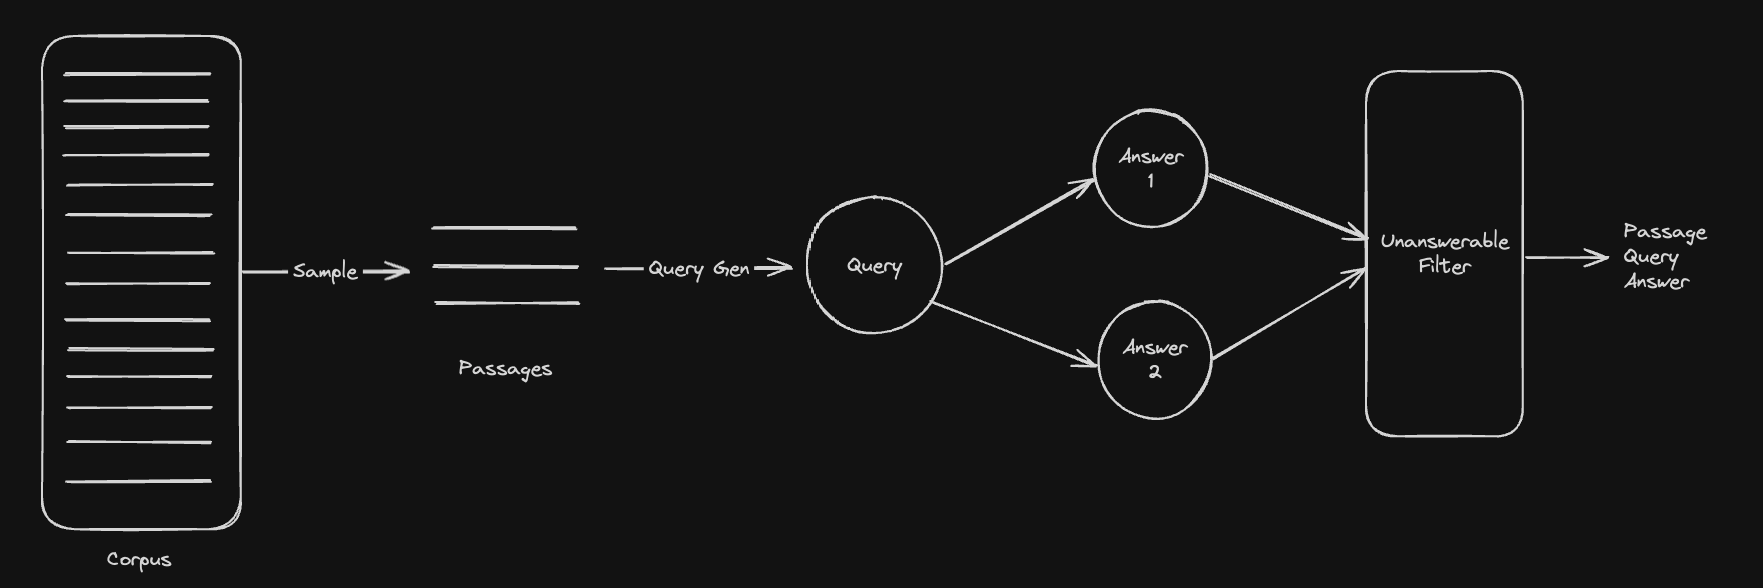

In [ ]:
# see the QA result
initial_qa.data.head()

,qid,retrieval_gt,retrieval_gt_contents,query,generation_gt
0,b1809744-5bdc-4f11-a4e2-f940e470b694,[[1fd2020d-7ce4-4533-b4aa-06766a66283b]],[[file_name: 1605.08386v1.Heat_bath_random_wal...,What is the stationary distribution for symmet...,[The stationary distribution for symmetric ran...
1,1b04a108-9ee9-4f7d-8738-ddbea7b09eda,[[5651e0d2-4bbb-4bd3-9643-8bcc0391c86e]],[[file_name: 2409.16176v1.Cyber_Knowledge_Comp...,"What is the F-Score for the model ""e5"" when us...","[The F-Score for the model ""e5"" when using the..."
2,3a3e152b-6a60-497c-8a7b-0cc81c176a51,[[a8bd49ec-fcfa-476b-834a-b36c19b50ef9]],[[file_name: 2409.16176v1.Cyber_Knowledge_Comp...,What are the key findings regarding the mappin...,[The key findings regarding the mapping perfor...


In [ ]:
initial_qa.data.iloc[0]["query"]

'What is the stationary distribution for symmetric random walks on a graph?'

In [ ]:
initial_qa.data.iloc[0]["generation_gt"]

['The stationary distribution for symmetric random walks on a graph is the uniform distribution on the set of vertices \\( V \\). This means that in a symmetric random walk, every vertex has an equal probability of being visited in the long run, which is a characteristic of the stationary distribution.',
 'Uniform distribution on V']

At result qa dataframe, you can see the five columns. The four columns is essential to the AutoRAG run.

- qid : The query's unique id
- retrieval_gt : The passage that can be evidence of the query. The doc_id from the linked corpus
- query : The question for the evaluation of RAG.
- generation_gt : The ground truth answer of the query.

# Update Corpus for chunking optimization

After optimizing pipeline once with initial qa and initial corpus, you can try to evaluate each different chunk setups.
Remember the vairous chunk results from the chunking phase?

Now, let's make different qa from the different corpus dataset. But query and the generation gt will be same.

This step is essential for the chunking optimization.

In [ ]:
new_corpus_df = pd.read_parquet("/content/chunk_project_dir/0/1.parquet")
new_corpus_instance = Corpus(new_corpus_df, raw_instance)

In [ ]:
new_qa = initial_qa.update_corpus(new_corpus_instance)
new_qa.to_parquet("/content/new_qa.parquet", "/content/new_corpus.parquet")

Now the new_qa will be the same query and generation_gt of the original qa dataframe, but retrieval gt will be differen to new corpus data.

That's it! Now you can use qa.parquet and corpus.parquet file at AutoRAG!

For more information, please see our [documentation](https://docs.auto-rag.com/data_creation/data_creation.html).
And join our [Discord server](https://discord.gg/P4DYXfmSAs) for question!